In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop

import os
import numpy as np
import matplotlib.pyplot as plt

import time


# %%
start = time.time()
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [2]:
folder_dir = os.getcwd()
base_dir = folder_dir + '/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=sample_count)
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
model = models.Sequential()
# VGG16 output shape (None, 4, 4, 512)
model.add(layers.Dense(256, activation='relu', input_dim=(4 * 4 * 512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# fine tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, 
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6122 - acc: 0.6615 - val_loss: 0.4441 - val_acc: 0.8360
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4309 - acc: 0.8110 - val_loss: 0.3616 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3636 - acc: 0.8430 - val_loss: 0.3279 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3221 - acc: 0.8580 - val_loss: 0.2998 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2936 - acc: 0.8810 - val_loss: 0.2819 - val_acc: 0.8870
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2644 - acc: 0.8900 - val_loss: 0.2827 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2465 - acc: 0.9070 - val_loss: 0.2781 - val_acc: 0.8800
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

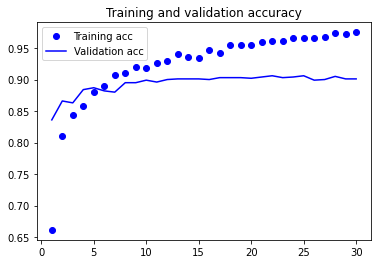

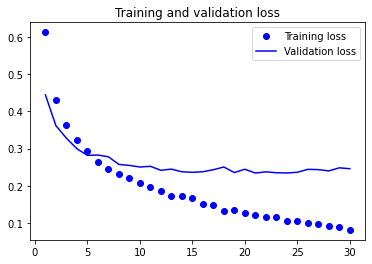

elapsed time: 35.55440640449524


In [4]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print(f"elapsed time: {time.time() - start}")